# Text Classification with Transformer on Chinese Dataset

## Setup

In [35]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300

In [36]:
print(tf.__version__)

2.4.1


## Transformer Block

![](../images/transformer-block.svg)
(<small>Source: [Transformers From Scratch](http://peterbloem.nl/blog/transformers)<small>)

In [37]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs) # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # layer norm
        ffn_output = self.ffn(out1) #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # layer norm

## Embedding and Position

-

In [38]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Data

No matter what data we are working with, we need to transform the text data as follows for deep learning computation:
- Texts in the corpus need to be randomized in order.
- All the input texts need to be transformed into integer sequences
- All the class labels need to be coded in numeric integers.
- Determine the vocabulary size and the maximum length of the input sequences.
- Padding the input sequences to ones of uniform lengths (i.e., the `max_len`).
- Do the train-test split.

```{note}
Categorical variable, like the class labels (i.e., `y`), can often be encoded in at least three ways:
    - Integer Encoding
    - One-hot Encoding
    - Learned Embedding (from pretrained models)
Please see Jason Brownlee's blog post, [How to prepare categorical data for deep learning in python](https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/) for more detail.
```

### Using NLTK Dataset

- Use the Marc's Thesis Data, Yahoo Movie Reviews.
- In deep learning, the general steps are as follows:
    - Load the corpus texts
    - Build the keras tokenizer
    - Fit the tokenizer on the corpus texts
    - Convert the word sequences of texts into integer sentences
    - Pad input lengths to uniform sizes

In [39]:
import nltk, random
from nltk.corpus import movie_reviews
import pandas as pd

In [40]:
df = pd.read_csv('../../../RepositoryData/data/marc_movie_review_metadata.csv')

In [41]:
df[:3]

,reviewID,title_CH,title_EN,genre,rating,reviews,reviews_sentiword_seg
0,Review_1,紫羅蘭永恆花園外傳－永遠與自動手記人偶－,Violet Evergarden - Eternity and the Auto Memo...,動畫,negative,唉，踩雷了，浪費時間，不推 唉，踩雷了，浪費時間，不推,唉 ， 踩 雷 了 ， 浪費 時間 ， 不 推 唉 ， 踩 雷 了 ， 浪費 時間 ， 不 推
1,Review_2,復仇者聯盟：終局之戰,Avengers: Endgame,動作_冒險,negative,片長三個小時，只有最後半小時能看，前面真的鋪陳太久，我旁邊的都看到打呼,片長 三個 小時 ， 只有 最後 半 小時 能 看 ， 前面 真的 鋪陳 太久 ， 我 旁邊...
2,Review_3,復仇者聯盟：終局之戰,Avengers: Endgame,動作_冒險,negative,史上之最，劇情拖太長，邊看邊想睡覺...... 1.浩克竟然學會跟旁人一起合照。 2.索爾...,史上 之 最 ， 劇情 拖 太長 ， 邊看邊 想 睡覺 . . . . . . 1. 浩克 ...


In [42]:
documents = [(t, l) for (t, l) in zip(df['reviews_sentiword_seg'], df['rating'])]

random.shuffle(documents) #in-place shuffle

In [43]:
# # documents = [(' '.join(movie_reviews.words(fileid)), category)
# #              for category in movie_reviews.categories()
# #              for fileid in movie_reviews.fileids(category)]
# random.shuffle(documents) #in-place shuffle

In [44]:
print('Number of Reviews/Documents: {}'.format(len(documents)))
print('Sample Text of Doc 1:')
print('-'*30)
print(documents[0][0][:50]) # first 50 words of the first document

Number of Reviews/Documents: 3200
Sample Text of Doc 1:
------------------------------
1. 劇情 緊湊 ， 內容 新鮮 2. 演技 到位 ， 演員 水平 高 3. 結局 收尾 驚奇 ， 


In [45]:
vocab_size= 10000
maxlen = 200  # Only consider the first 200 words of each movie review

texts = np.array([t for (t,l) in documents])
labels = np.array([0 if l=='negative' else 1 for (t,l) in documents])
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)

In [46]:
# now the data consists of a sequence of word index integers
texts_to_int = tokenizer.texts_to_sequences(texts)

In [47]:
texts_len = [len(t) for t in texts_to_int]

To determine the `max_len` for training can be important sometimes.

A good heuristic is to take a look at the text length distribution of the corpus and see how much proportion of the texts you would like to disregard.

/Users/Alvin/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

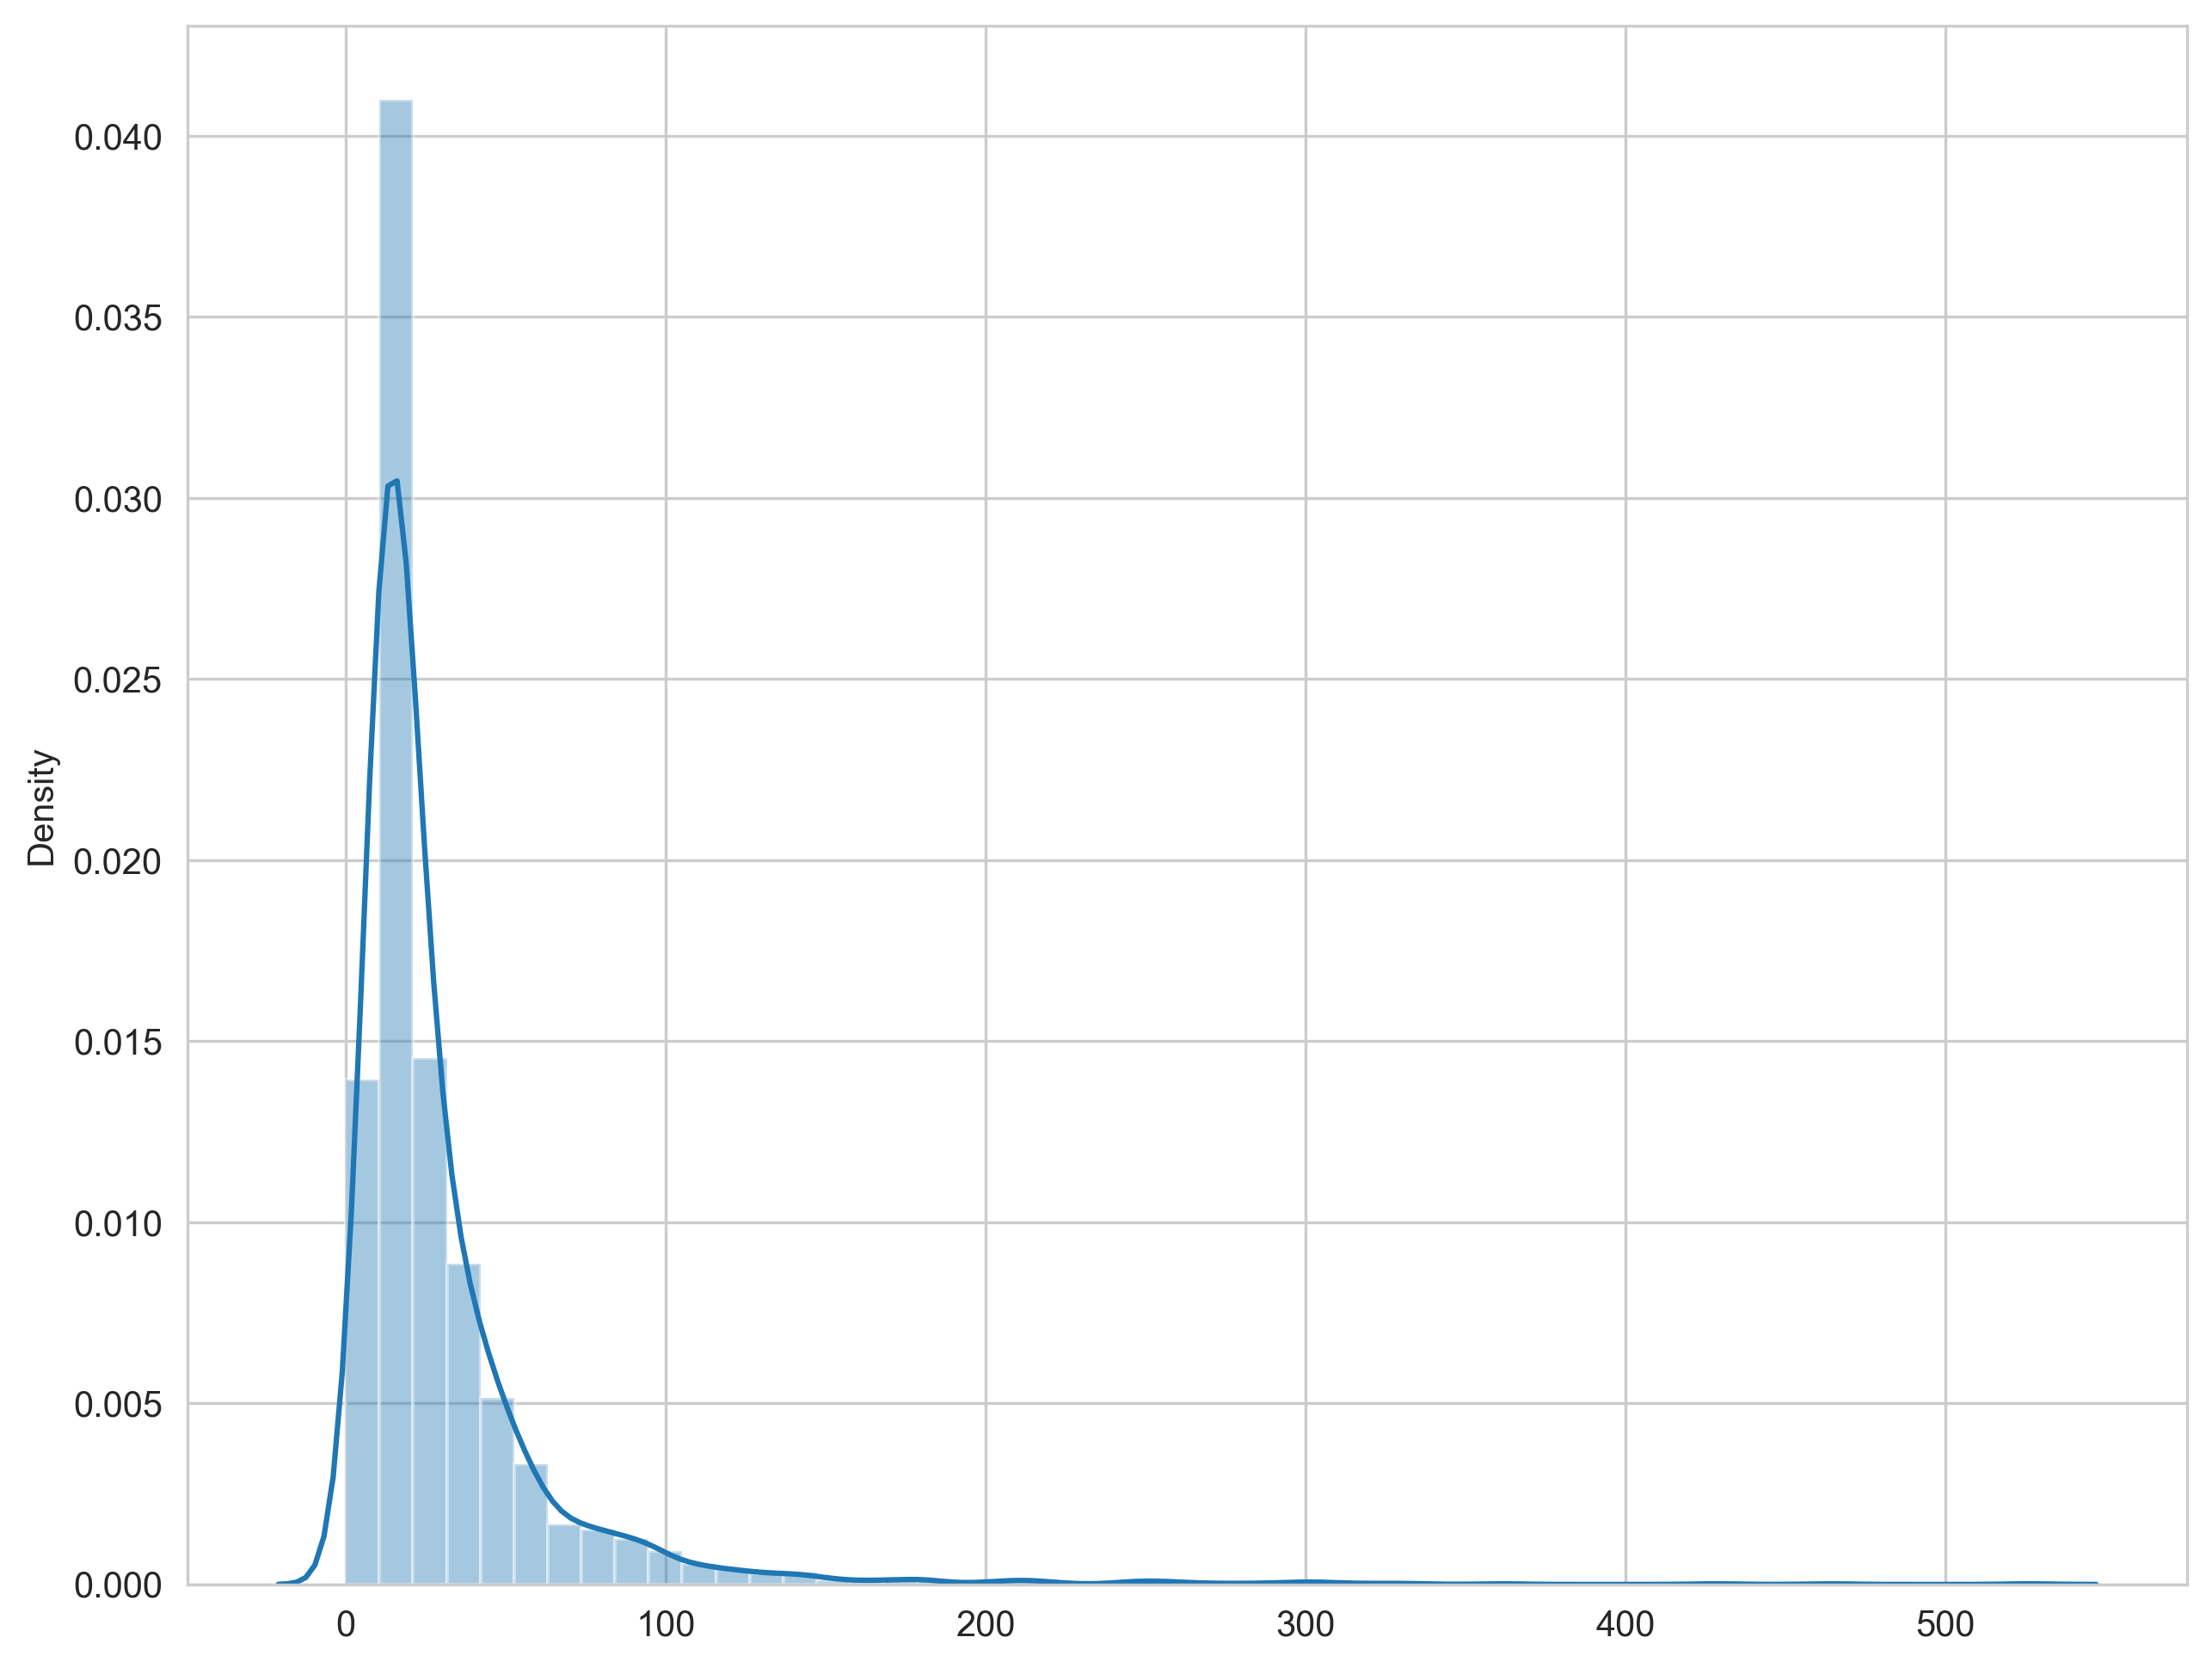

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.figure(figsize=(10,8))
sns.distplot(texts_len)

In [49]:
texts_to_int_pad = keras.preprocessing.sequence.pad_sequences(texts_to_int, maxlen=maxlen)

In [50]:
len(texts_to_int_pad[0])

200

In [63]:
document2= [(t,s, l) for t, s, l in zip(texts, texts_to_int_pad, labels)]

In [64]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(document2, test_size = 0.1, stratify=labels,random_state=42)

In [75]:
x_train = np.array([x for (_,x,y) in train])
y_train = np.array([y for (_,x,y) in train])
x_val = np.array([x for (_,x,y) in test])
y_val = np.array([y for (_,x,y) in test])
x_val_text = np.array([x for (x,_,y) in test])

In [66]:
# check the proportion of pos neg texts in both train and val
print(np.bincount(y_train))
print(np.bincount(y_val))

[1440 1440]
[160 160]


In [55]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(2880, 200)
(2880,)
(320, 200)
(320,)


In [56]:
# Check Vocab Size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 10720


### Using Original Keras Tutorial Dataset

In [57]:
# vocab_size= 20000
# maxlen = 200  # Only consider the first 200 words of each movie review
# (x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
# print(len(x_train), "Training sequences")
# print(len(x_val), "Validation sequences")
# x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
# x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

## Define Classifier Architecture

In [58]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

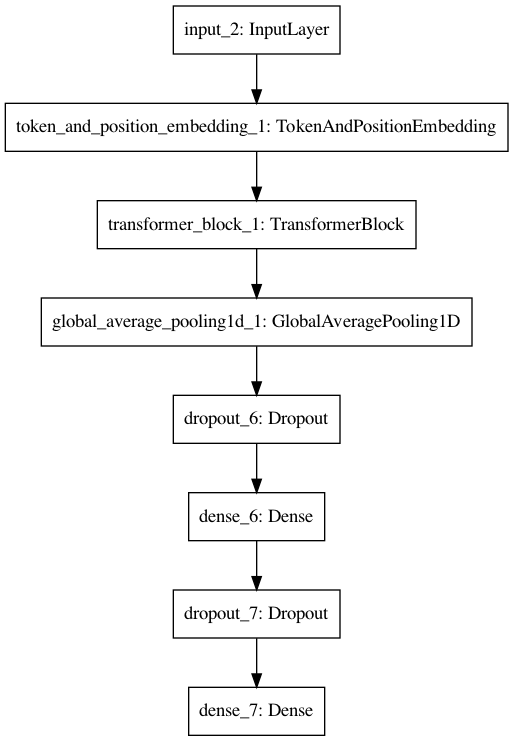

In [59]:
keras.utils.plot_model(model)

## Training

In [60]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val)
)

Epoch 1/10
90/90 [==============================] - 8s 76ms/step - loss: 0.7190 - accuracy: 0.5091 - val_loss: 0.6922 - val_accuracy: 0.4969
Epoch 2/10
90/90 [==============================] - 6s 72ms/step - loss: 0.6920 - accuracy: 0.5167 - val_loss: 0.6878 - val_accuracy: 0.5500
Epoch 3/10
90/90 [==============================] - 6s 70ms/step - loss: 0.6848 - accuracy: 0.5651 - val_loss: 0.6520 - val_accuracy: 0.8062
Epoch 4/10
90/90 [==============================] - 6s 68ms/step - loss: 0.5322 - accuracy: 0.7393 - val_loss: 0.3188 - val_accuracy: 0.8656
Epoch 5/10
90/90 [==============================] - 6s 68ms/step - loss: 0.1592 - accuracy: 0.9452 - val_loss: 0.2975 - val_accuracy: 0.8813
Epoch 6/10
90/90 [==============================] - 6s 68ms/step - loss: 0.0693 - accuracy: 0.9806 - val_loss: 0.3482 - val_accuracy: 0.8656
Epoch 7/10
90/90 [==============================] - 6s 65ms/step - loss: 0.0262 - accuracy: 0.9941 - val_loss: 0.4648 - val_accuracy: 0.8750
Epoch 8/10
90

## Ploting Training Results

Loss Function

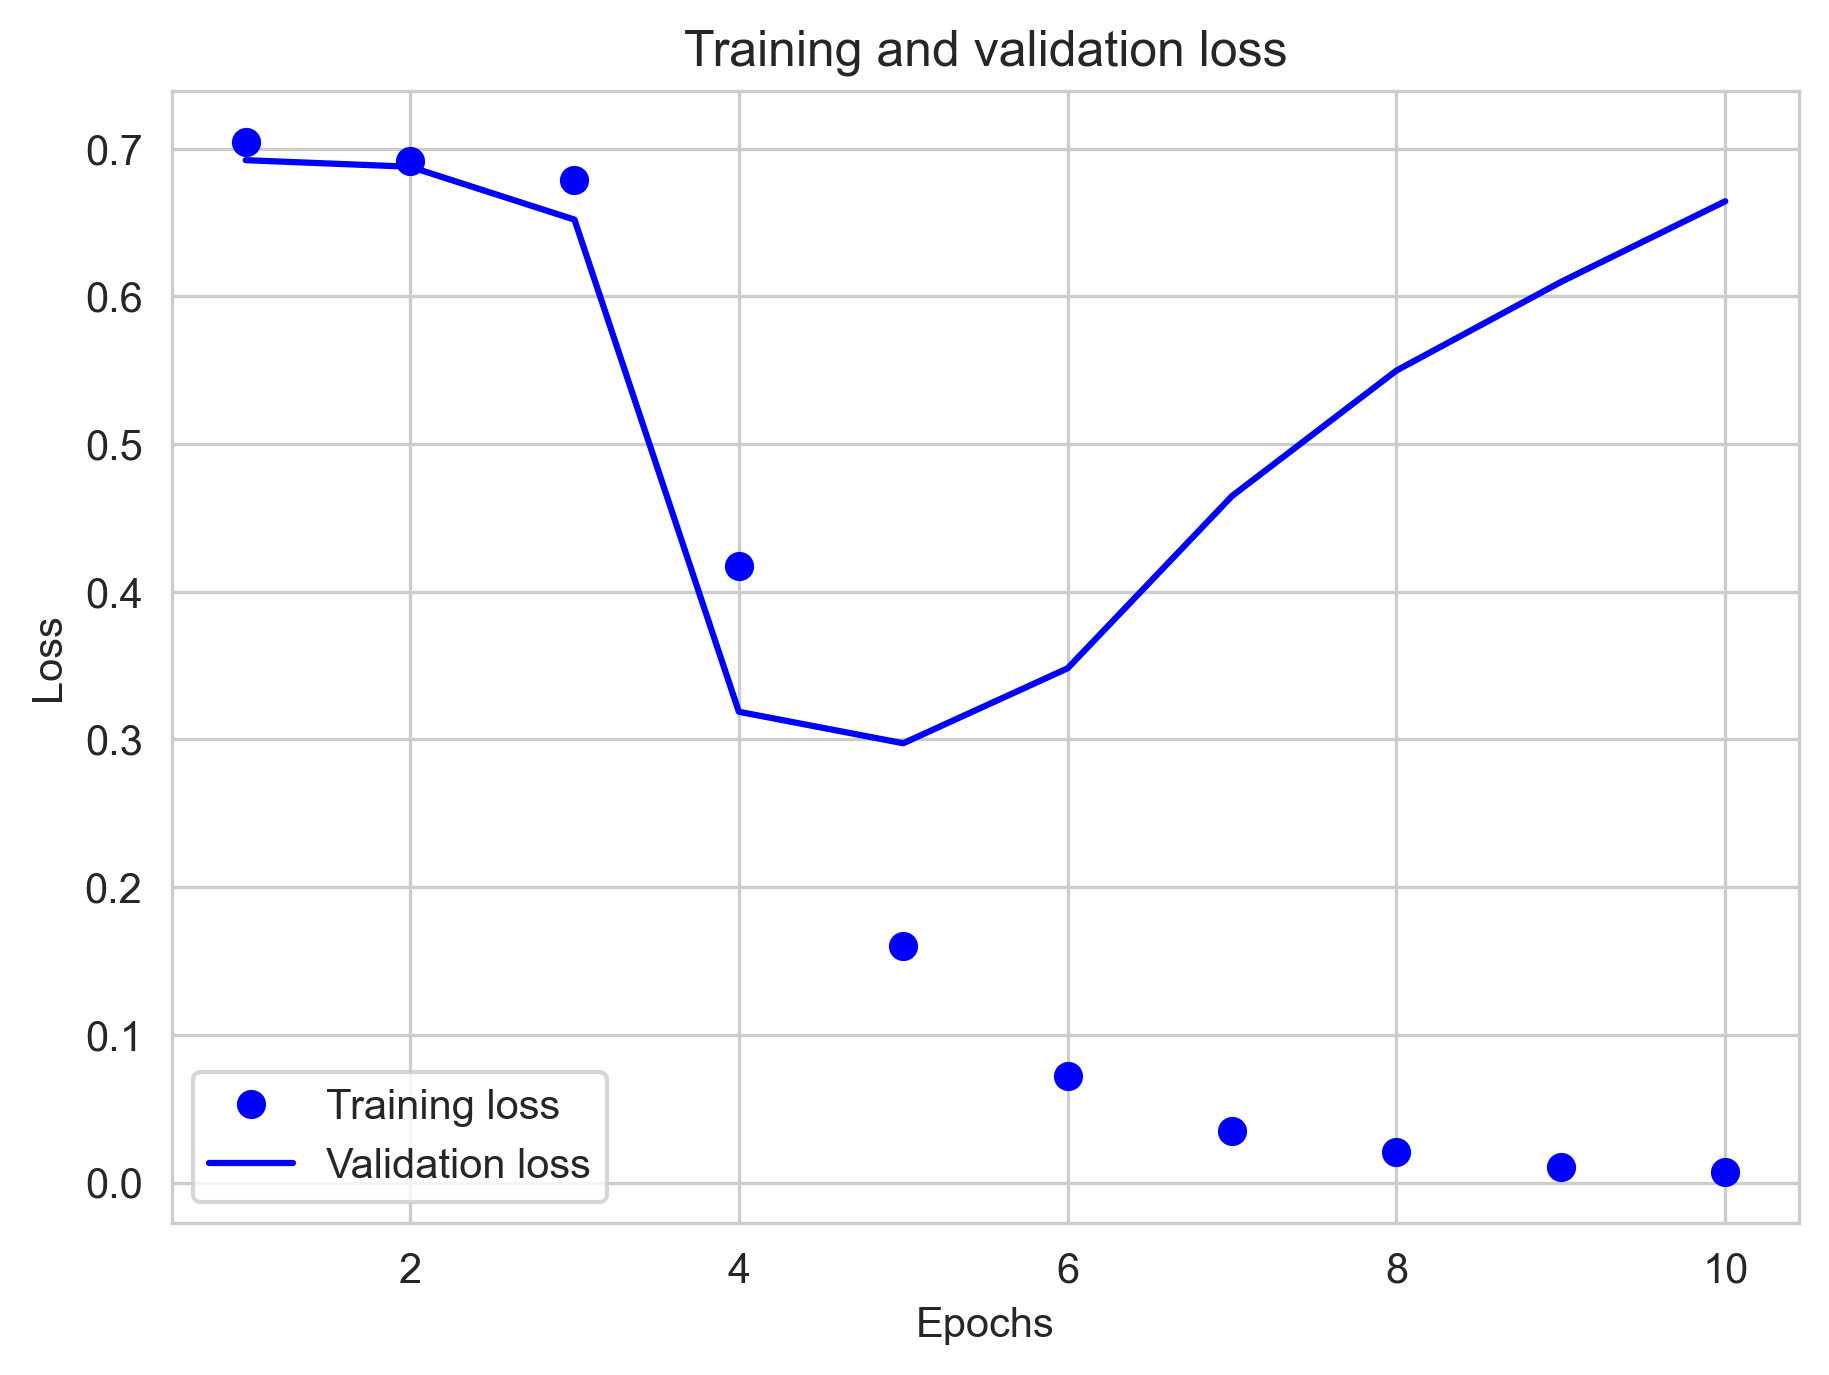

In [126]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(val_loss_values) + 1)


plt.figure(figsize=(7,5))
plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Validation

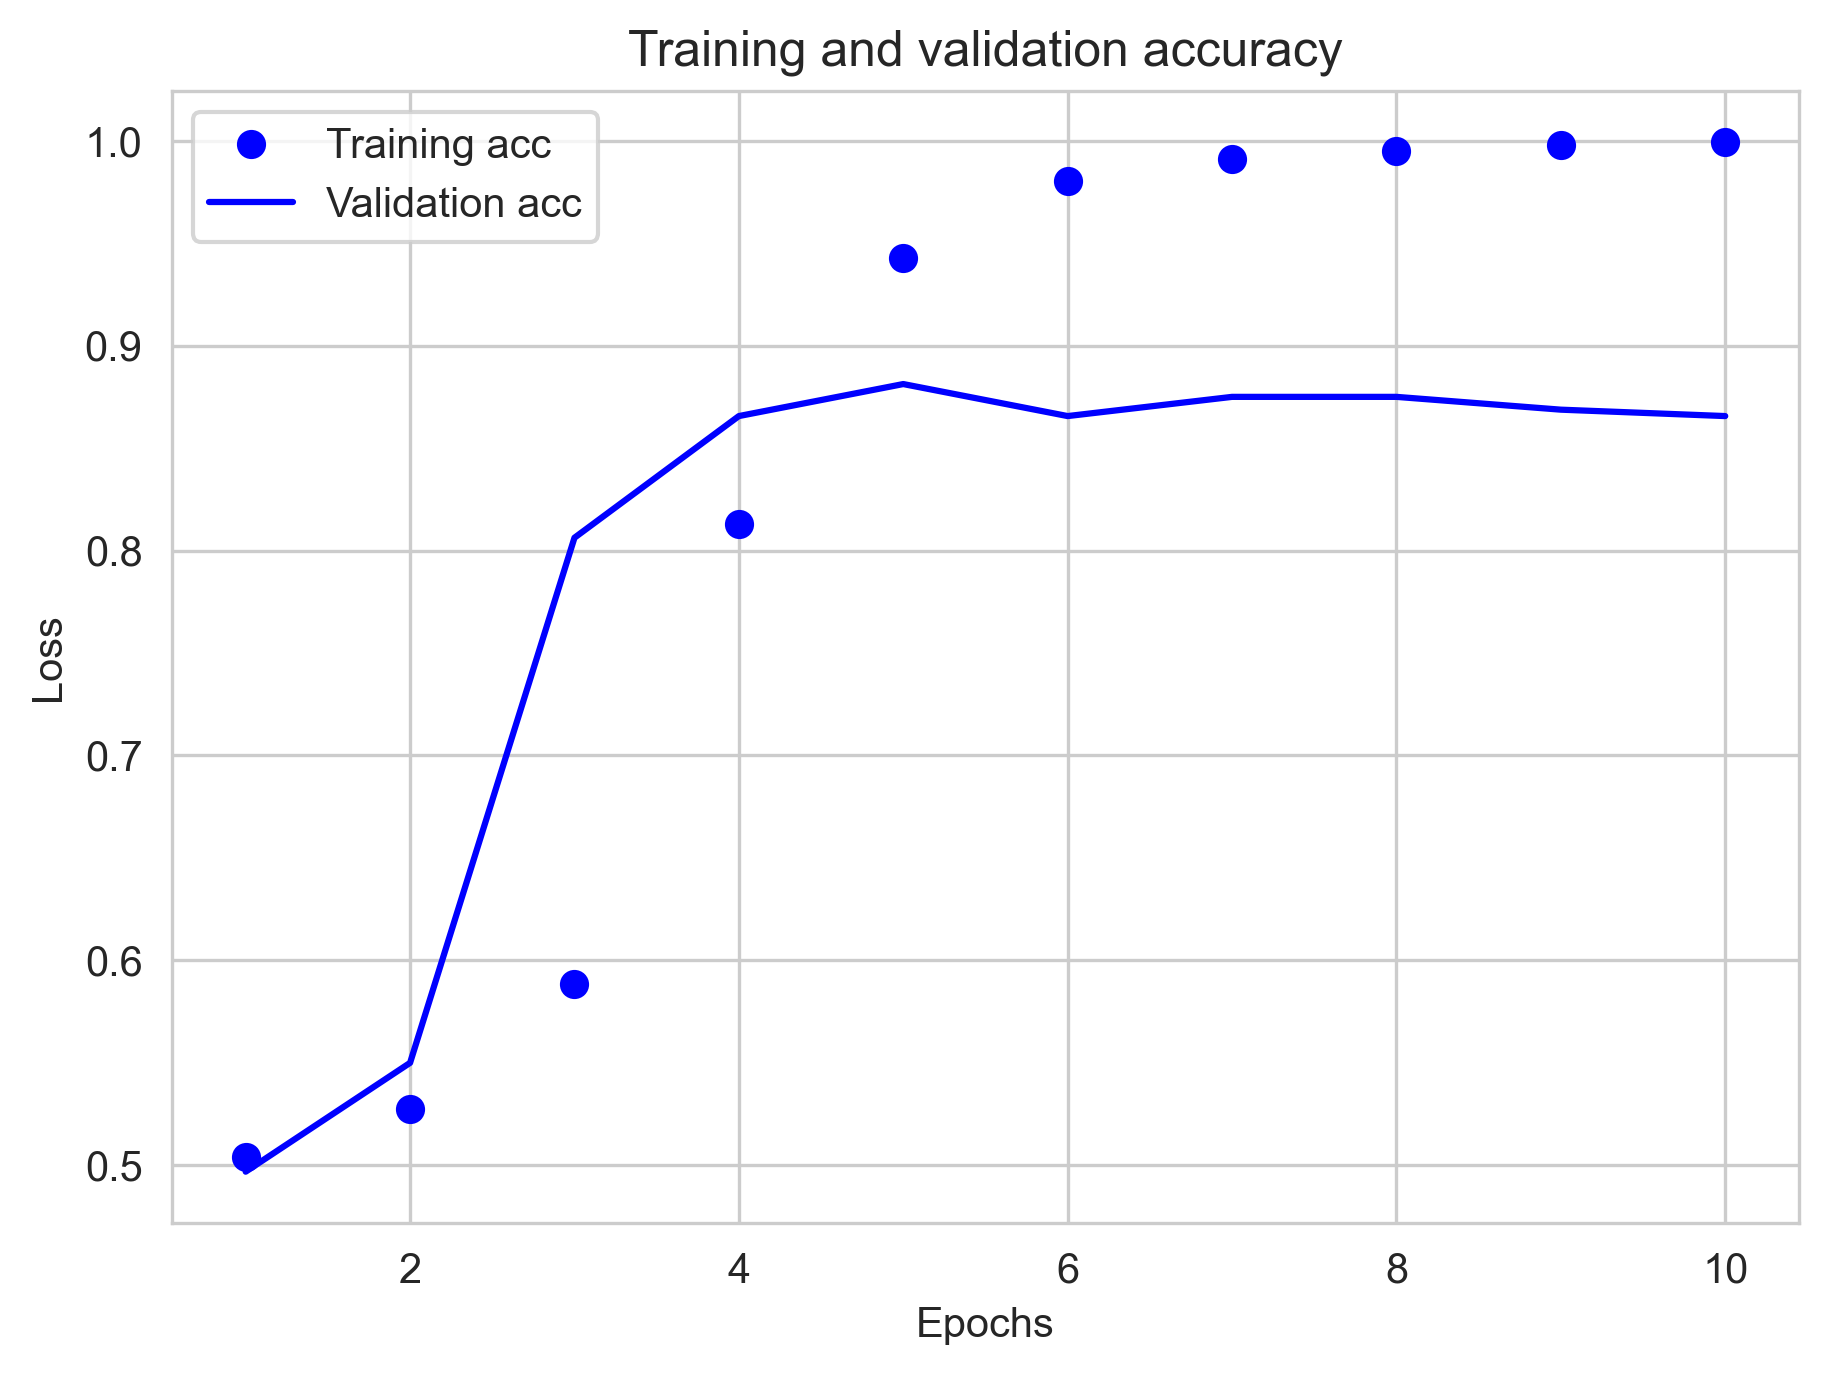

In [127]:

acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy']
plt.figure(figsize=(7,5))
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()
plt.show()


Given the small corpus size, it is clear to see that our model starts to overfit the training set quite a bit after the first few epoches.

In real application development, we may improve the model by:
- increasing the datasets
- inceasing the embedding dimensions
- using pretrained embeddings
- playing with the transformer blocks in terms of depths and widths of the layers

## Explanation

In [93]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["negative","positive"])

In [94]:
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=maxlen)
    #return np.array([[float(1-x), float(x)] for x in model.predict(np.array(_seq_pad))])
    return model.predict(np.array(_seq_pad))
    

In [105]:
def explain_text(text):
    exp = explainer.explain_instance(
    text, model_predict_pipeline, num_features=100, top_labels=1)
    exp.show_in_notebook(text=True)

In [114]:
explain_text(x_val_text[4])

In [115]:
reversed_word_index = dict([(index, word) for (word, index) in tokenizer.word_index.items()])

In [116]:
text_id = 4

In [117]:
x_val[text_id]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [118]:
x_val_text[text_id]

'不要 相信 那些 1 顆星 2 顆星 \r \n \r \n 史上 最強 怪獸 電影'

In [119]:
' '.join([reversed_word_index.get(i, '?') for i in x_val[text_id]])

'? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 不要 相信 那些 1 顆星 2 顆星 \r \r 史上 最強 怪獸 電影'

In [120]:
model.predict(x_val[[text_id]])

array([[0.3452008, 0.6547992]], dtype=float32)

In [121]:
model_predict_pipeline(x_val_text[[text_id]])

array([[0.3452008, 0.6547992]], dtype=float32)

In [122]:
exp = explainer.explain_instance(
x_val_text[text_id], model_predict_pipeline, num_features=100, top_labels=1)

In [123]:
exp.show_in_notebook(text=True)

## References

- [Text classification with transfomer](https://keras.io/examples/nlp/text_classification_with_transformer/)
- [Transformers From Scratch](http://peterbloem.nl/blog/transformers)